In [3]:
import numpy as np
import sympy as sp
import pickle
from joblib import Parallel, delayed
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from functions.simulation_functions import param_scan

In [4]:
# run a paramater scan across p and q values
ics        = np.array([[1], [0]]) #    start with one sensitive cell and zero resistant cells
num_gens   = 30                         # simulate for 10 generations
num_trials = 10000                      # run 10,000 trials for each parameter pair

p_vals = np.arange(0, 1.0500, 0.050)   # vary p from 0 to 1 with 0.05 increments
q_vals = np.arange(0, 1.0500, 0.050)   # vary p from 0 to 1 with 0.05 increments

sim_data = param_scan(ics, num_gens, num_trials, p_vals, q_vals) # index using `sim_data[p_idx, q_idx, trial#, gen#, cell_type]`

Simulating (p, q) pairs: 100%|██████████| 441/441 [00:53<00:00,  8.24it/s]


In [5]:
# open theory expressions for µ_n and v_n:
theory_dir = './thr_output'
with open(os.path.join(theory_dir, 'mu_n.pkl'), 'rb') as file:
    mu_n = pickle.load(file)
with open(os.path.join(theory_dir, 'v_n.pkl'), 'rb') as file:
    v_n  = pickle.load(file)

# p, q: real numbers in [0, 1]
p = sp.Symbol('p', real=True, nonnegative=True)    # probability of becoming resistant from sensitive
q = sp.Symbol('q', real=True, nonnegative=True)    # probability of becoming sensitive from resistant

# n: integer
n = sp.Symbol('n', integer=True, nonnegative=True) # number of generations

# initial conditions for mean, µ0_1, µ0_2: real numbers
mu_0_1 = sp.Symbol('mu_0_1', real=True, nonnegative=True)
mu_0_2 = sp.Symbol('mu_0_2', real=True, nonnegative=True)
mu_0   = sp.Matrix([[mu_0_1], [mu_0_2]])

# initial conditions for variance, v0_1, v0_2, v0_3: real numbers
v_0_1 = sp.Symbol('v_0_1', real=True, nonnegative=True)
v_0_2 = sp.Symbol('v_0_2', real=True, nonnegative=True)
v_0_3 = sp.Symbol('v_0_3', real=True, nonnegative=True)
v_0   = sp.Matrix([[v_0_1], [v_0_2], [v_0_3]])

In [6]:
# calculate the theoretical mean and variances for the simulated parameter sets

# use parallelization to speed up

thr_data = np.zeros((len(p_vals), len(q_vals), 2, num_gens+1, 2)) # index using `thr_data[p_idx, q_idx, {0: mean, 1: var}, gen#, cell_type]`

# computation for one set (i, j, p_val, q_val, n_val)
def compute_entry(i, j, n_val, p_val, q_val):
    mean = mu_n.subs({p: p_val, q: q_val, n: n_val, mu_0_1: 1, mu_0_2: 0})
    var  = v_n.subs({p: p_val, q: q_val, n: n_val, mu_0_1: 1, mu_0_2: 0, v_0_1: 0, v_0_2: 0, v_0_3: 0})

    var = np.array([v if v.is_real else np.nan for v in var])

    return (i, j, n_val, [mean[0], mean[1]], [var[0], var[2]])


tasks = [(i, j, n_val, p_val, q_val)
         for i, p_val in enumerate(p_vals)
         for j, q_val in enumerate(q_vals)
         for n_val in range(num_gens+1)]

results = Parallel(n_jobs=-1)(
    delayed(compute_entry)(i, j, n_val, p_val, q_val)
    for i, j, n_val, p_val, q_val in tqdm(tasks, desc="Computing µ and v")
)

for i, j, n_val, mu, var in results:
    thr_data[i, j, 0, n_val, :] = mu
    thr_data[i, j, 1, n_val, :] = var


Computing µ and v: 100%|██████████| 13671/13671 [01:50<00:00, 123.90it/s]


In [7]:
# 1a) compare the simulated and theoretical mean and variances

sim_mean = np.mean(sim_data[:, :, :, num_gens, 1], axis=2)
thr_mean = thr_data[:, :, 0, num_gens, 1]

sim_var  = np.var(sim_data[:, :, :, num_gens, 1], axis=2)
thr_var  = thr_data[:, :, 1, num_gens, 1]

# calculate the absolute and relative error between the means
# if both thr_var and sim_var == 0, set rel_error = 0
# if thr_var == 0 but sim_var != 0, set rel_error = np.nan
mean_abs_error = np.abs(sim_mean - thr_mean)
mean_rel_error = np.where(
    (thr_mean == 0) & (sim_mean == 0), 0.0,
    np.abs(sim_mean - thr_mean) / np.where(thr_mean == 0, np.nan, thr_mean)
)
mean_rel_error *= 100

# calculate the absolute and relative errors between the variances
var_abs_error = np.abs(sim_var - thr_var)
var_rel_error = np.where(
    (thr_var == 0) & (sim_var == 0), 0.0,
    np.abs(sim_var - thr_var) / np.where(thr_var == 0, np.nan, thr_var)
)
var_rel_error *=100

/var/folders/s3/fqn33qvd1h38qvwbb7b8f52w0000gn/T/ipykernel_65032/4098478143.py:23: RuntimeWarning: invalid value encountered in divide
  np.abs(sim_var - thr_var) / np.where(thr_var == 0, np.nan, thr_var)


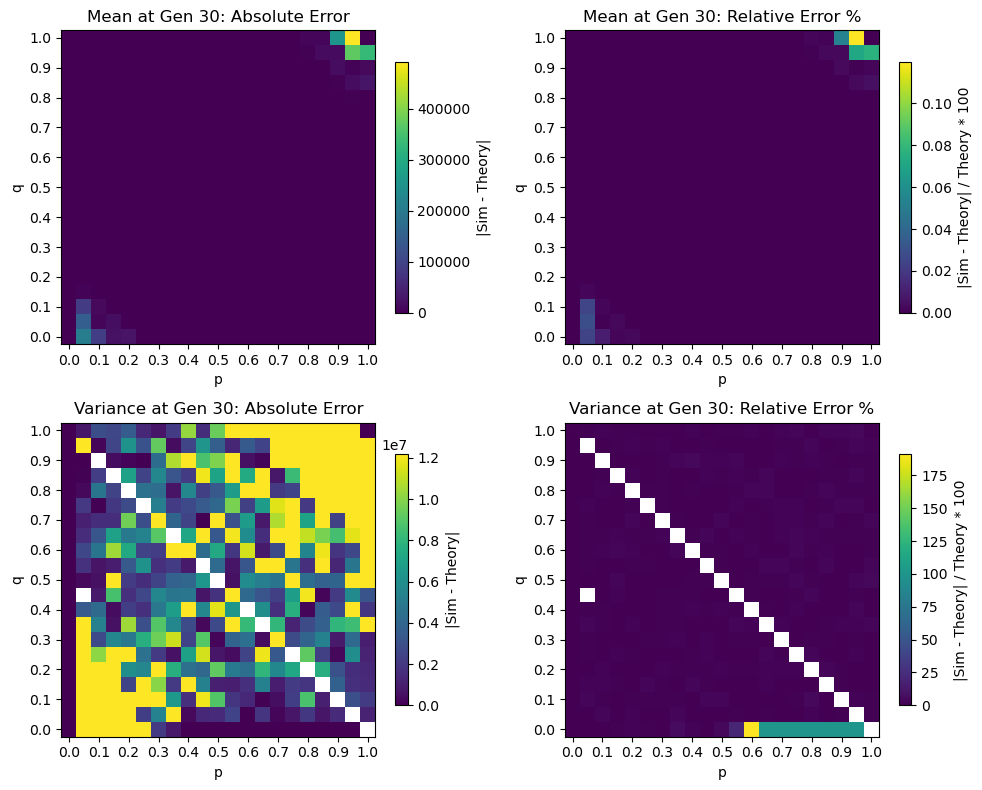

In [8]:
# 1b) visualize error results with a heatmap
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

im00 = axs[0, 0].imshow(mean_abs_error.T, origin='lower', vmin=0)
axs[0, 0].set_title(f'Mean at Gen {num_gens}: Absolute Error')
fig.colorbar(im00, ax=axs[0, 0], label='|Sim - Theory|', shrink=0.8)

im01 = axs[0, 1].imshow(mean_rel_error.T, origin='lower', vmin=0)
axs[0, 1].set_title(f'Mean at Gen {num_gens}: Relative Error %')
fig.colorbar(im01, ax=axs[0, 1], label='|Sim - Theory| / Theory * 100', shrink=0.8)

im10 = axs[1, 0].imshow(var_abs_error.T, origin='lower', vmin=0, vmax=np.percentile(var_abs_error[~np.isnan(var_abs_error)], 75))
axs[1, 0].set_title(f'Variance at Gen {num_gens}: Absolute Error')
fig.colorbar(im10, ax=axs[1, 0], label='|Sim - Theory|', shrink=0.8)

im11 = axs[1, 1].imshow(var_rel_error.T, origin='lower', vmin=0)
axs[1, 1].set_title(f'Variance at Gen {num_gens}: Relative Error %')
fig.colorbar(im11, ax=axs[1, 1], label='|Sim - Theory| / Theory * 100', shrink=0.8)

for i in range(2):
    for j in range(2):
        axs[i, j].set_xticks(np.arange(len(p_vals))[::2])
        axs[i, j].set_xticklabels(np.round(p_vals[::2], 2))
        axs[i, j].set_xlabel('p')

        axs[i, j].set_yticks(np.arange(len(q_vals))[::2])
        axs[i, j].set_yticklabels(np.round(q_vals[::2], 2))
        axs[i, j].set_ylabel('q')

plt.tight_layout()
plt.show()